# Size of SARS-Cov2 virions

© 2021 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

This notebook is heavily inspired by this [lesson](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/lessons/lesson_05/segmentation.html#Segmentation-by-edge-detection) by Justin Bois.

***

In [1]:
import os

# For numerical computation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

# For image analysis
import skimage.io
import skimage.filters
import skimage.morphology
import scipy.ndimage
import skimage.segmentation

# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'
pn.extension()
sns.set()

In this notebook we will take a look at images obtained with electron microscopy of SARS-Cov2 virions outside a cell. This images were sent to us by Elizabeth Fischer. We will try to identify the virion particles in the image and then obtain their diameter. 

Image analysis is far from trivial, and often there are many different ways one can take to come to a conclusion, and rarely there is one optimal way. So here we explore two different ways of identifying virions, but there are many more ways to get equivalent or even better results.

## Load images

Here we define the path to the location where the images are stored. Change this accordingly. We use `skimage` to read the image.

In [2]:
# Define directory where images exist
filepath = "../../data/VeroCells-24hSARS-CoV2_i013.tif"

# Read example image into memory
im = skimage.io.imread(filepath)

# Let's show an image
im

array([[180, 148, 147, ..., 102, 104,  96],
       [158, 168, 161, ...,  91,  98,  95],
       [164, 151, 131, ...,  91,  95,  92],
       ...,
       [ 83,  87,  87, ..., 213, 217, 229],
       [ 81,  87,  95, ..., 223, 211, 228],
       [ 89,  88,  82, ..., 216, 220, 206]], dtype=uint8)

Here we can see that this image is simply a two dimensional array of integers. From this matrix of integers we are going to identify virions and determine their size.

We write a short function to plot images, since we will be doing this task quite a lot.

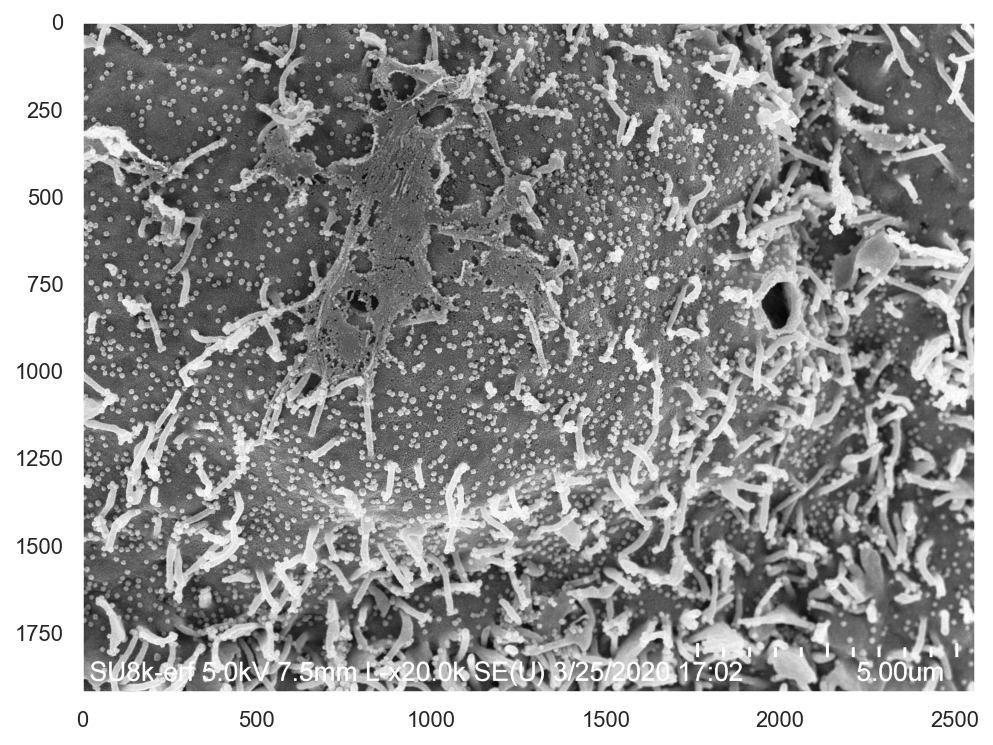

In [3]:
def plot_image(im, cmap=plt.cm.Greys_r, scale=1):
    "Returns a image representation of a 2D array"
    fig, ax = plt.subplots(figsize=(8 * scale, 8 * scale))
    ax.imshow(im, cmap=cmap, aspect=1)
    ax.grid(False)
    return ax

plot_image(im);

For image analysis, we cut out the scale bar. We will come back to the scale bar later.

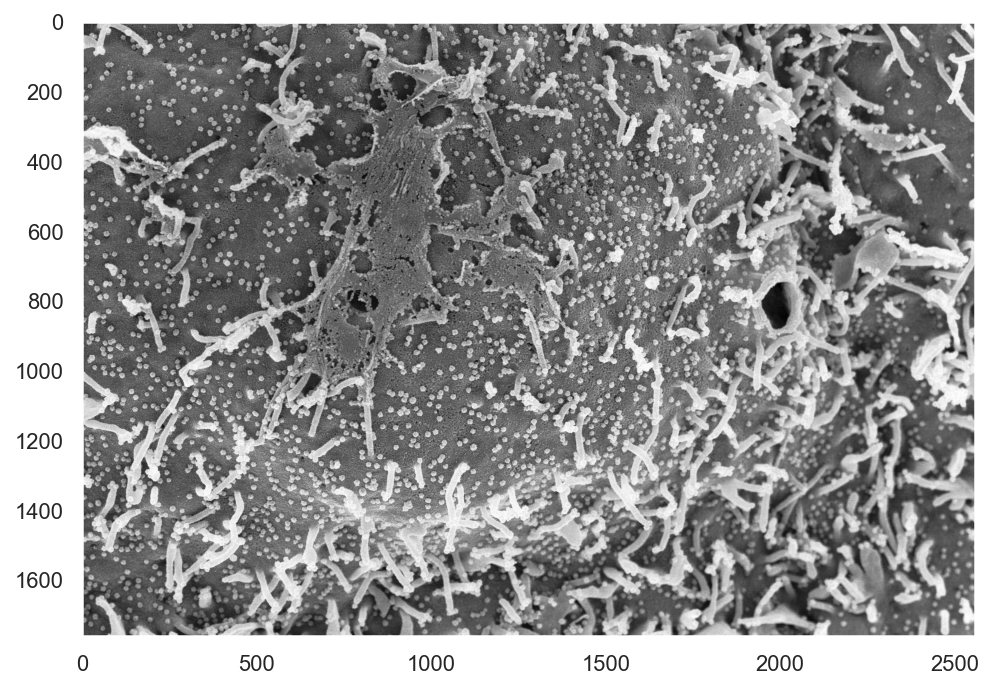

In [4]:
im_cut = im[0:1760, :]

plot_image(im_cut);

## Thresholding

First we are going to try to identify particles by thresholding, meaning we are telling the computer that a particle relates to a pixel with an intensity that is larger than a certain value. In order to do that, we are going to do some preparation steps.

### Background subtraction

First, we try to get rid of any background, such that a pixel intensity corresponding to a virion is the same across the image. For that purpose, we transform the image to an array of floats of values between 0 and 1.

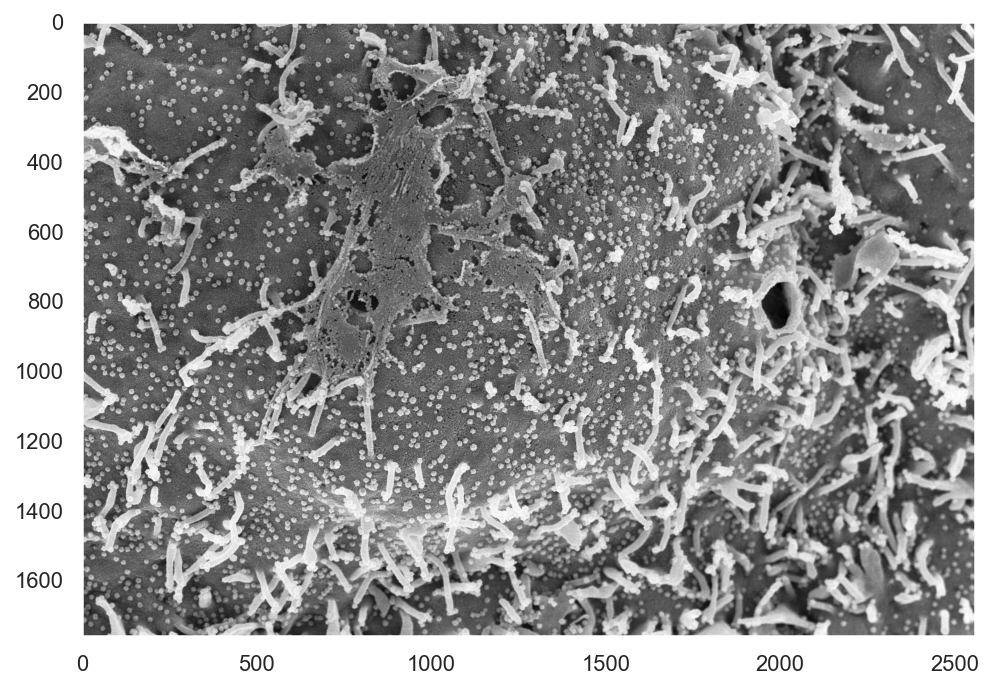

In [5]:
# Transform to float
im_float = (im_cut.astype(float) - np.min(im_cut)) / (np.max(im_cut) - np.min(im_cut))

plot_image(im_float);

As we can see, we have not changed the image yet, but simply transformed the scale and type of the values in the array.

The background can be obtained by using a Gaussian filter with large radius. Using this filter, each pixel is replaced by an weighted average of its surrounding pixels, where the pixel are weighted by a 2D Gaussian distribution. Any details in the image get averaged out, and only large scale variations remain.

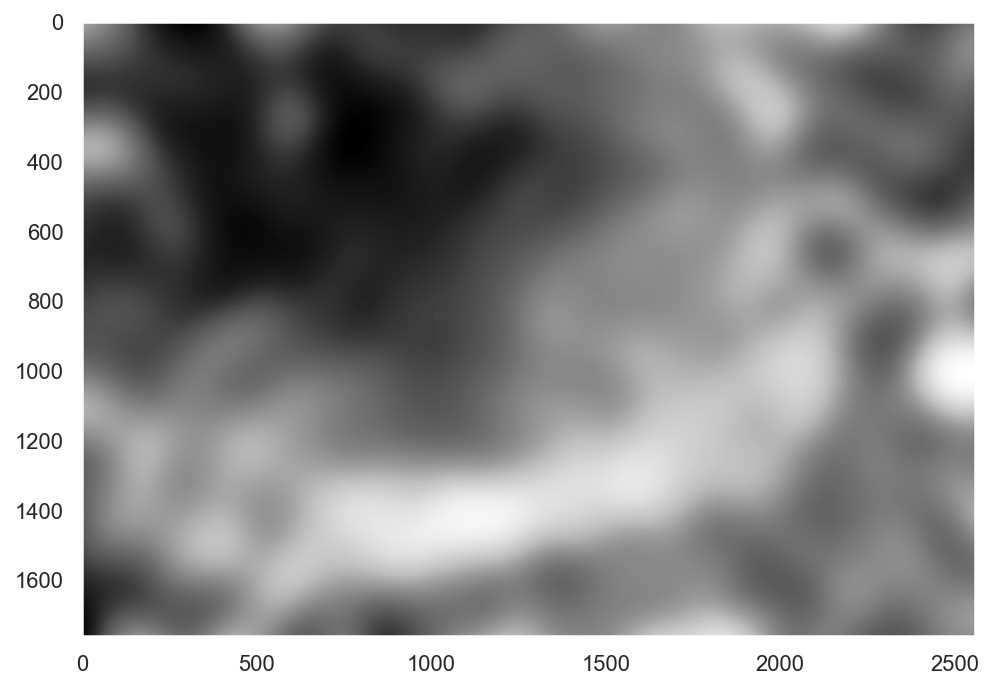

In [6]:
# Filter the image with a strong Gaussian blur
im_bg = skimage.filters.gaussian(im_float, 75.0)

plot_image(im_bg);

We cannot identify a single particle in the image anymore, however, we can see the edges of the cell in the background. Let's subtract the background from the image and take a look.

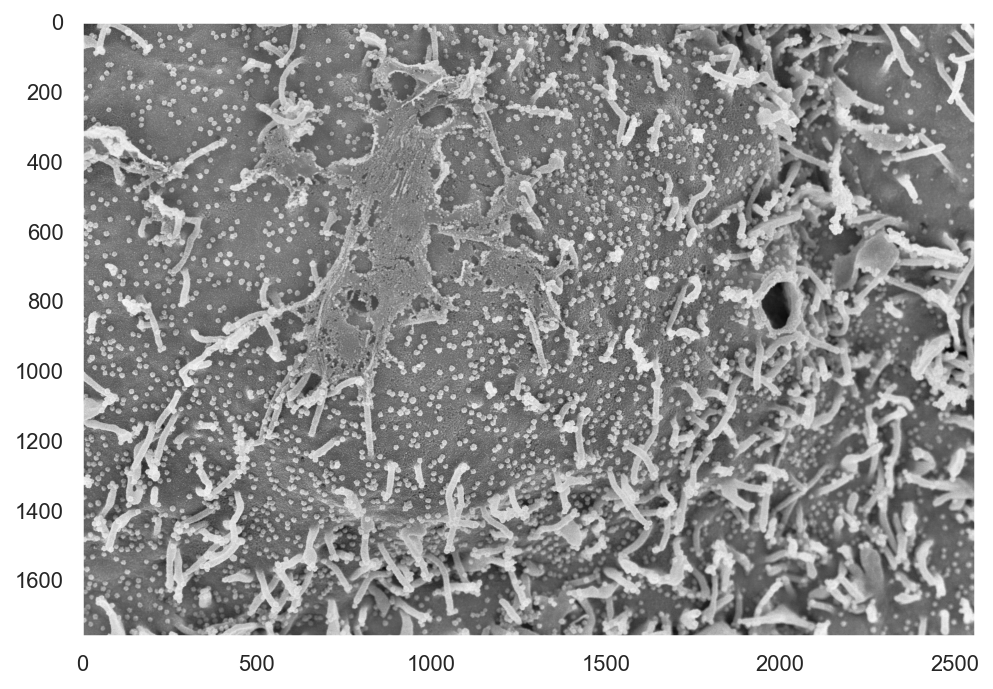

In [7]:
# Compute array as float
im_float = (im_cut - np.min(im_cut)) / (np.max(im_cut) - np.min(im_cut))

# Subtract background
im_float = im_float - im_bg

# Rescale image
im_float = (im_float - np.min(im_float)) / (np.max(im_float) - np.min(im_float))

# Show image
plot_image(im_float);

To simplify further analysis, we can look at the part of the image that contains most virions, excluding the part which looks like a pore and sets the lower bound for pixel intensities.

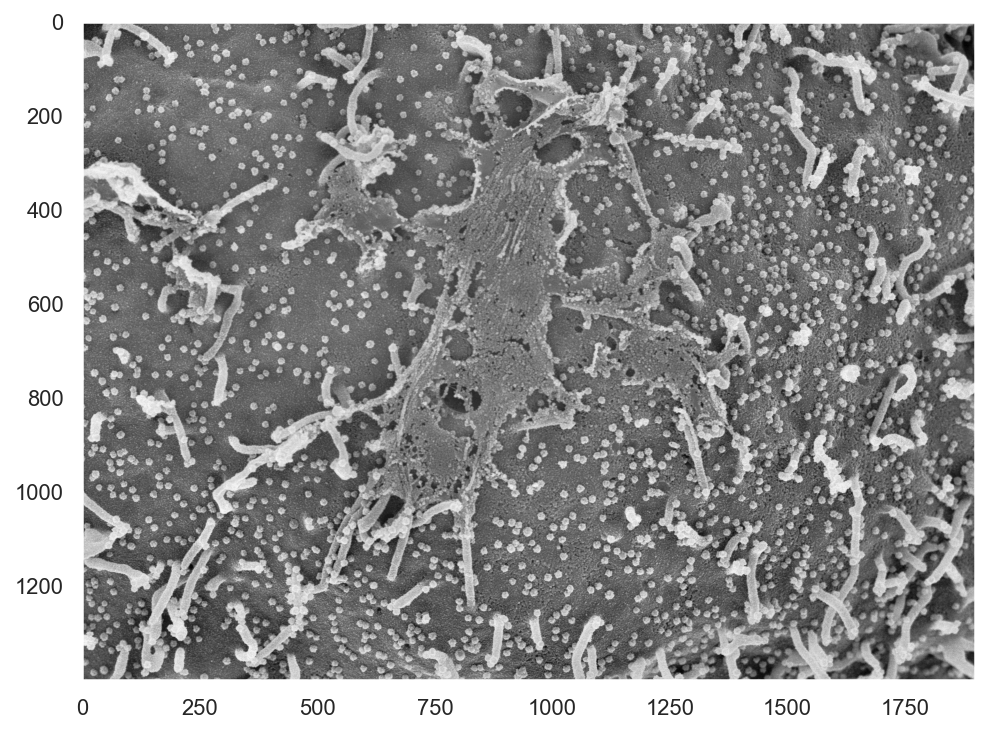

In [8]:
# Take part of image
im_zoom = im_float[:1400, :1900]

# Rescale image
im_zoom = (im_zoom - np.min(im_zoom)) / (np.max(im_zoom) - np.min(im_zoom))

# Plot rescaled image
plot_image(im_zoom);

This gave us a better contrast of the virions to the cell. The next step is to identify the virion particles and separate them from the cell in the background. Let's zoom in so we can get a better look at some virions.

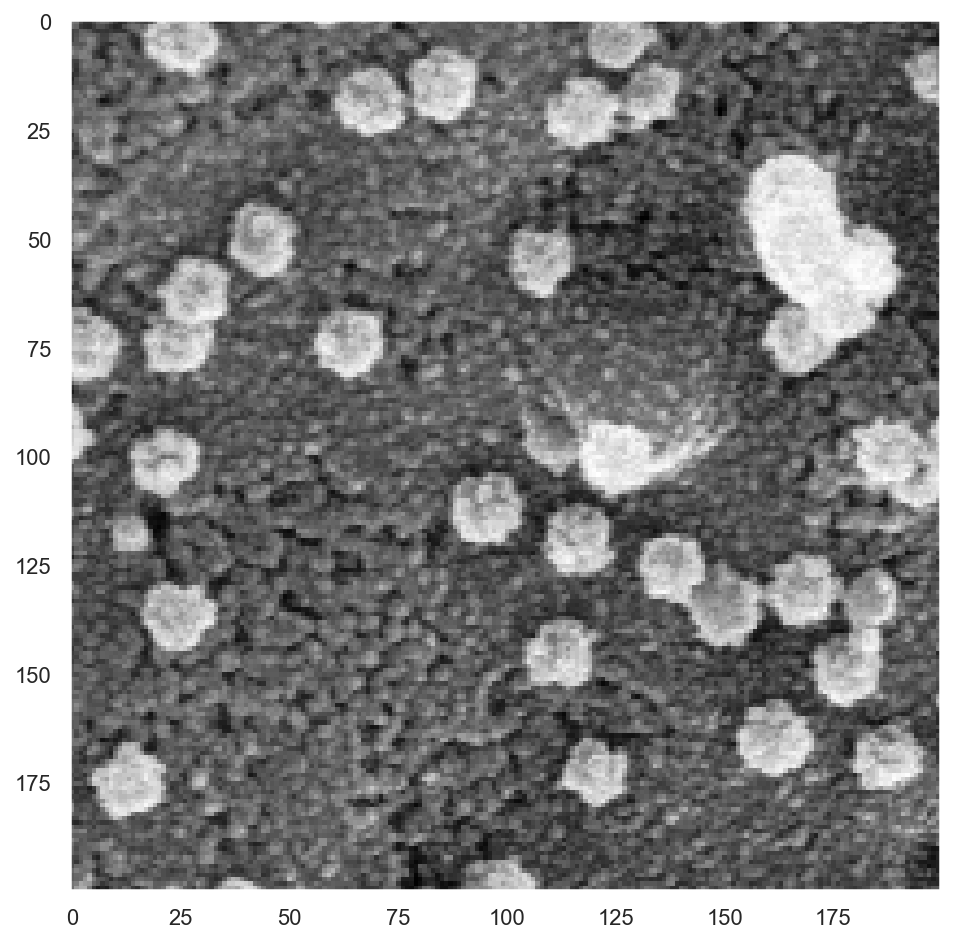

In [9]:
zoom = np.s_[1000:1200, 1000:1200]

plot_image(im_zoom[zoom]);

### Filtering

There is a lot of "noise" going on in the background. We can smooth this out by using a Gaussian filter with small radius.

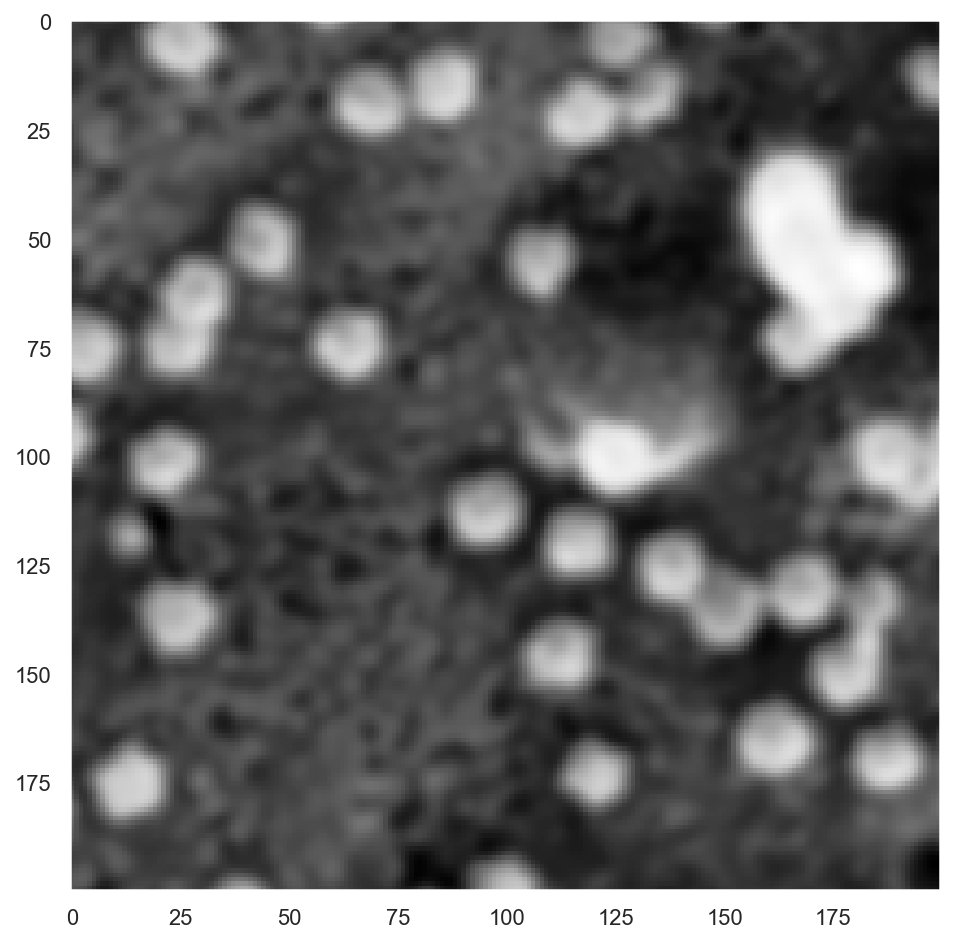

In [10]:
# Filter image
im_filt = skimage.filters.gaussian(im_zoom, 2)
im_filt = (im_filt - np.min(im_filt)) / (np.max(im_filt) - np.min(im_filt))

# Plot filtered image
plot_image(im_filt[zoom], cmap=plt.cm.Greys_r);

### Choosing a threshold

Now that we have put a filter on the image, let's look at the distribution of pixel intensities in the image. 

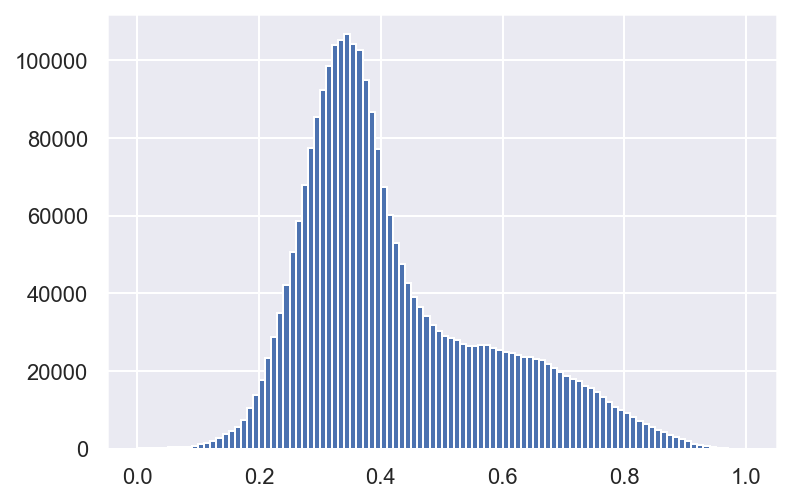

In [11]:
plt.hist(im_filt.flatten(), bins=100);

We can see that there are two modes in the distribution. The large peak at lower pixel intensities belongs to the background, while the second mode at higher intensities belongs to pixels of particles. We want to find the optimal threshold that keeps as many virion pixels as possible, while keeping the background pixels at a minimum. Here we are simply eyeballing a single value for the threshold, but there are may ways of computing an "optimal" threshold.

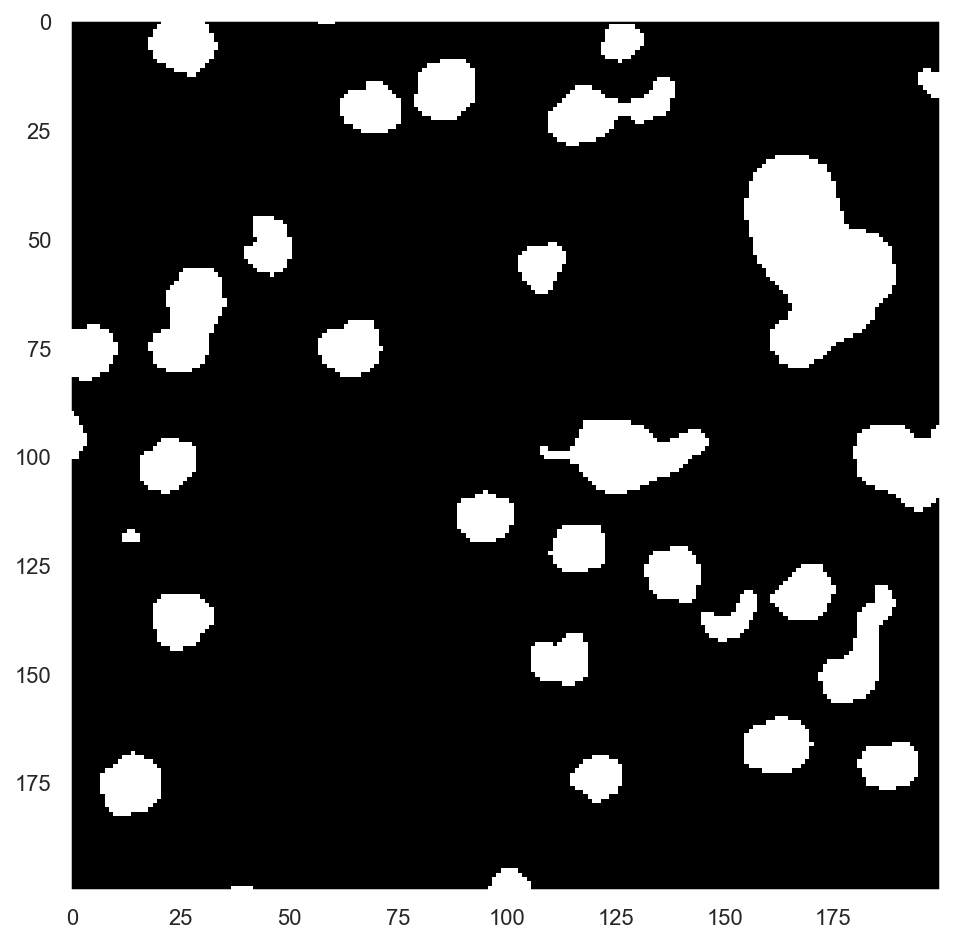

In [12]:
im_thresh = im_filt > 0.6

plot_image(im_thresh[zoom]);

We did a good job at identifying particles. However, we also removed pixels that belonged to particles. We could spend more time trying to optimze thresholding, but we will proceed to another method of identifying particels called **edge detection**.

## Edge detection

In this part we will try to identify particels by their edges. Edges are regions of high gradient in pixel intensity, where the intensity changes rapidly from background to the particle.

## Filtering

Before we try to identify the edges of particles, we will have to filter the image again. Here we are using a ranking median filter. This filter takes all pixels in the area of the pixel, ranks them by their intensity, and then replaces the pixel value by the median of the ranked intensities. Therefore, we need to decide which pixels we are ranking, meaning we need to define a geometry. There are many geometries to choose from, but here we are choosing a disk. One also has to define the size of the object. Here we are going with a rather small object, since we want to separate virions that are close to each other.

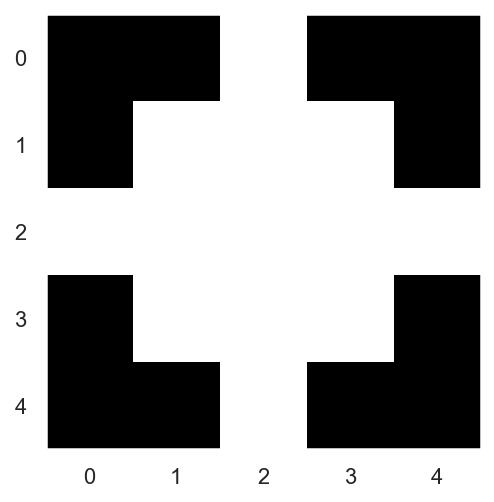

In [13]:
# Choose mask
selem = skimage.morphology.disk(2)

# Show mask
plot_image(selem, scale=0.5);

Let's apply this filter to the image and see what we get.

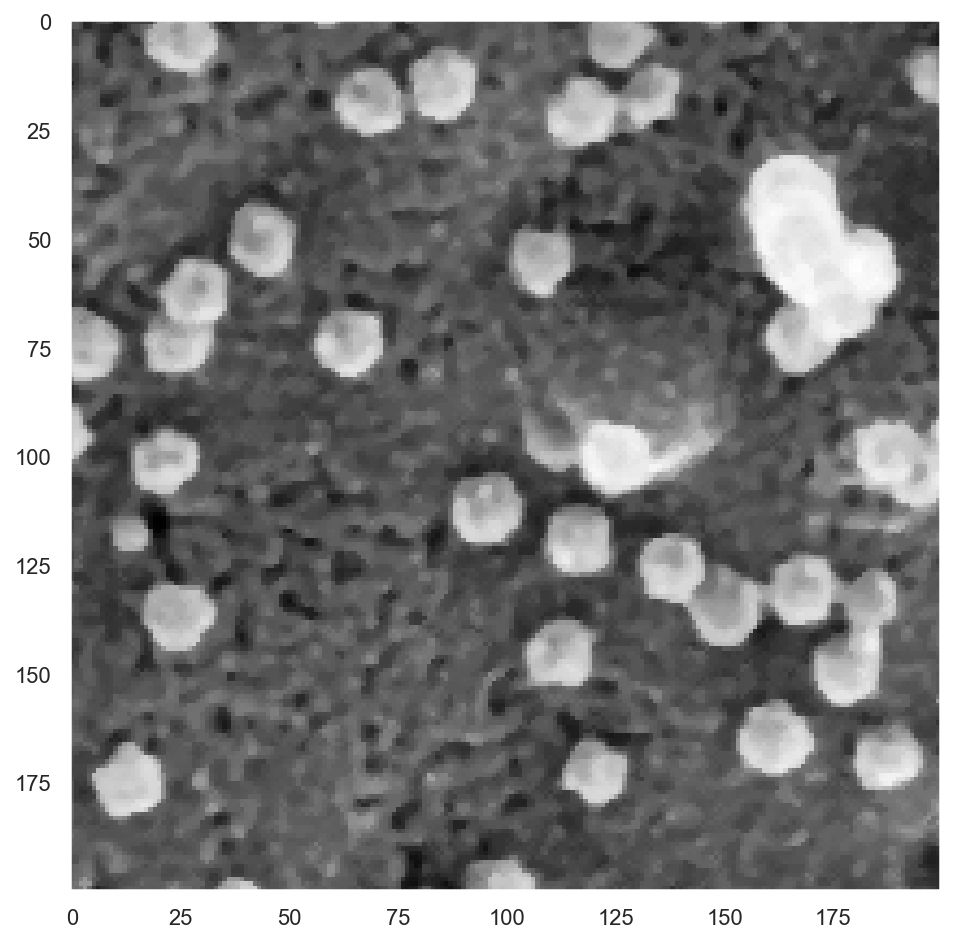

In [390]:
# Apply rank filter
im_filt = skimage.filters.rank.median(im_cut, selem)

# Plot filtered image
plot_image(im_filt[zoom]);

### Finding edges

While the background still is not that smooth, the particles stand out more compared to it, which makes it easier to detect them. To detect the edges of the particles, we are using a so called "canny" edge detection, which is a series of operations, including computing the gradient in pixel values and finding areas with high gradients. The result is a binary image, similar to an image obtained by thresholding, where the highlighted pixels are found edges.

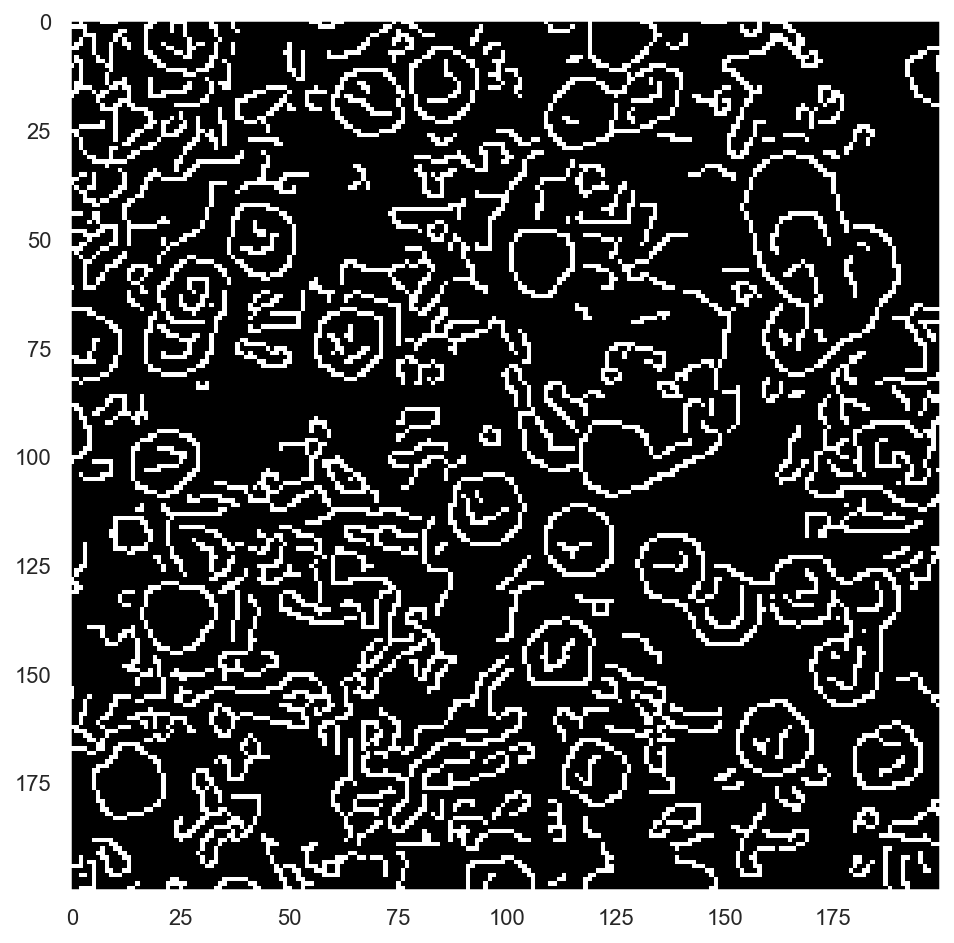

In [391]:
# Apply canny edge detection
im_edge = skimage.feature.canny(im_filt, sigma=1)

# Plot edges
plot_image(im_edge[zoom]);

There is still some gibberish around. However, we can try to fill all closed areas, followed by removing small objects (much smaller than the virions). 

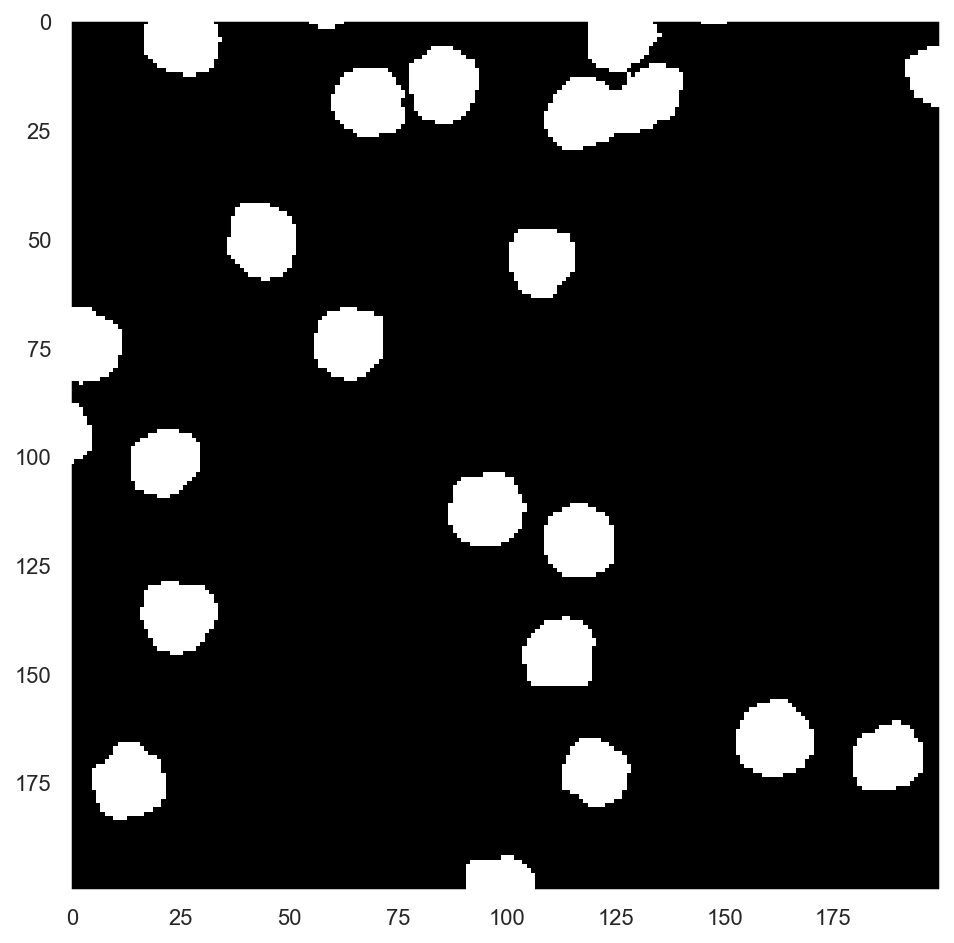

In [392]:
# Fill holes
im_edge = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Remove small objects
im_bw = skimage.morphology.remove_small_objects(im_edge, min_size=100)

# Plot result
plot_image(im_bw[zoom]);

This looks really good! We got rid of most gibberish, while keeping the virions we are interested in. Also, they kept a nice round shape, as we could see by eye in the original image. Let's have a look at the entire image to see if there are regions where our edge detection failed.

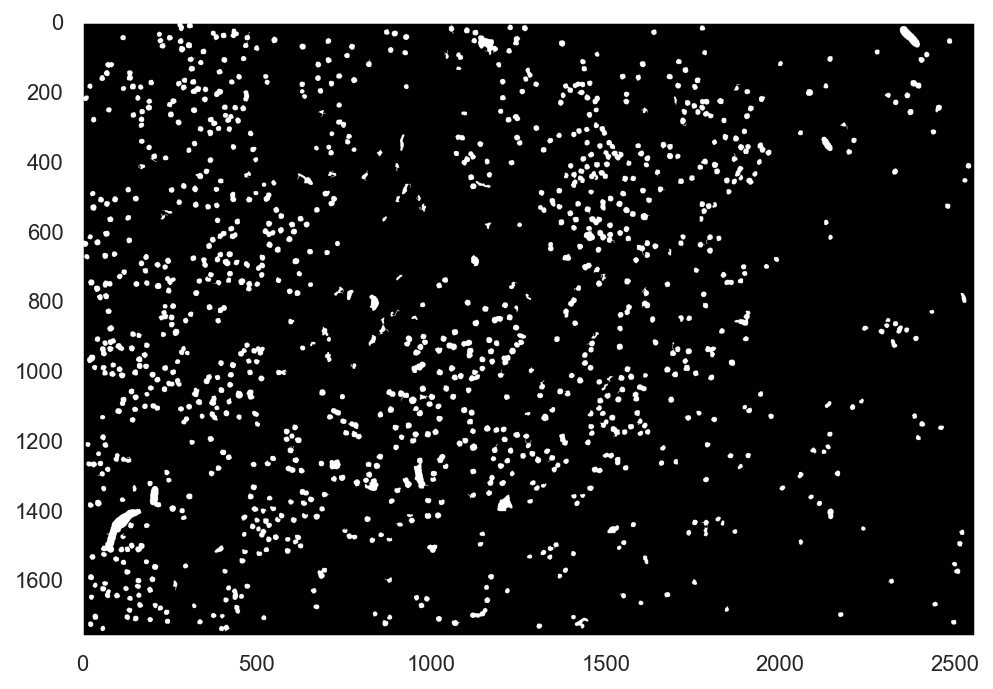

In [393]:
plot_image(im_bw);

Wow. With a couple of exceptions we were able to extract plenty of virions from the image. 

### Extract features

Now we need to label the particels so we can extract some features, such as size and eccentricity. To do this, we can use the `skimage.measure.label` function, which takes as input the image we just obtained. We also need to tell the function which value in the array belongs to the background, so it can correctly identify the virions.

Number of individual objects =  1033


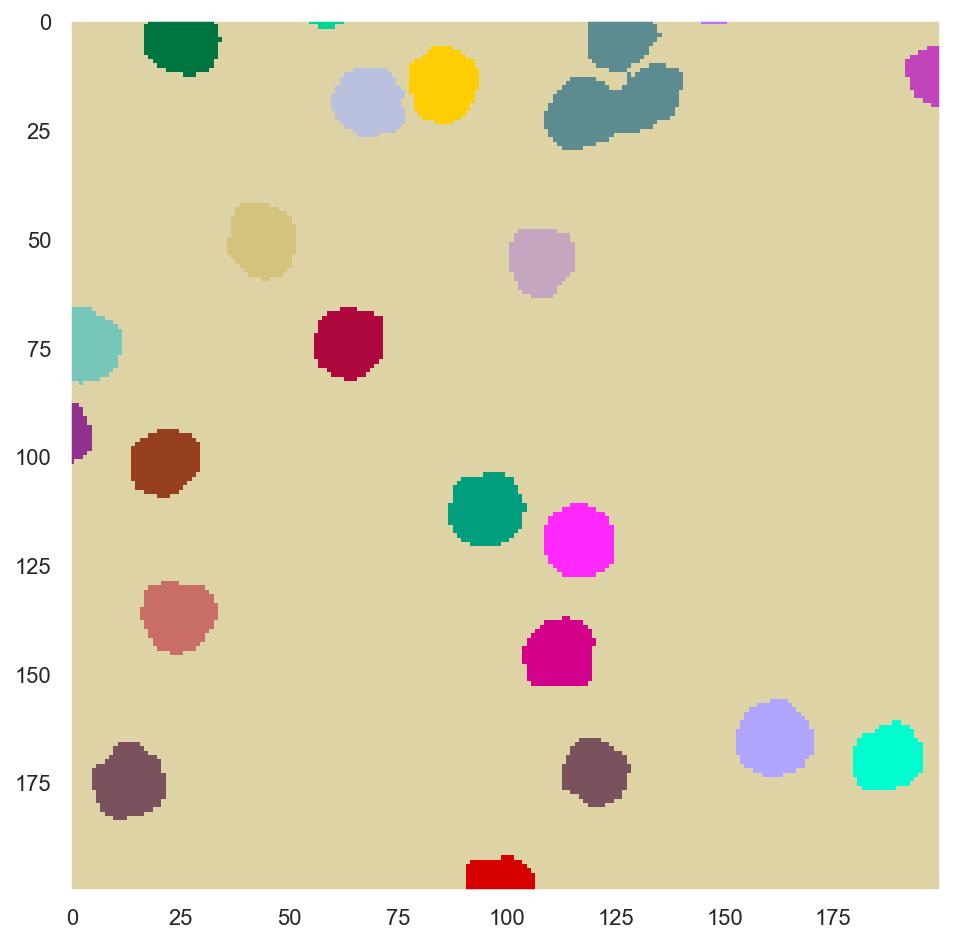

In [394]:
# Label binary image
im_labeled, n_labels = skimage.measure.label(im_bw, background=0, return_num=True)

# Show number of objects
print("Number of individual objects = ", n_labels - 1)


# Show the result
plot_image(im_labeled[zoom], cmap=cc.cm.glasbey_light_r);

We can use this labeled image to compute properties of each object. The function `skimage.measure.regionprops` does exactly that. It computes various properties for each object which we can extract and write into a dataframe.

In [398]:
# Get properties of each particle
im_props = skimage.measure.regionprops(im_labeled)

# Extract features
data = [[prop.label, prop.area, prop.eccentricity] for prop in im_y_props]

# Write features into dataframe
df = pd.DataFrame(
    data=data, columns=["label", "area (sq ip distance)", "eccentricity"]
)

# Take a look
df

label  area (sq ip distance)  eccentricity
0        1                    314      0.805218
1        2                    207      0.423267
2        3                    176      0.294110
3        4                    212      0.485740
4        5                    188      0.461371
..     ...                    ...           ...
940    941                    174      0.412619
941    942                    133      0.643143
942    943                    183      0.179700
943    944                    175      0.254303
944    945                    144      0.463235

[945 rows x 3 columns]

Now it is time to look at the scale bar. We want to find the distance between each pixel to compute the diameter of the virions. A single interval of the scale bar is 500nm. Now we need to count how many pixels are separating each bar.

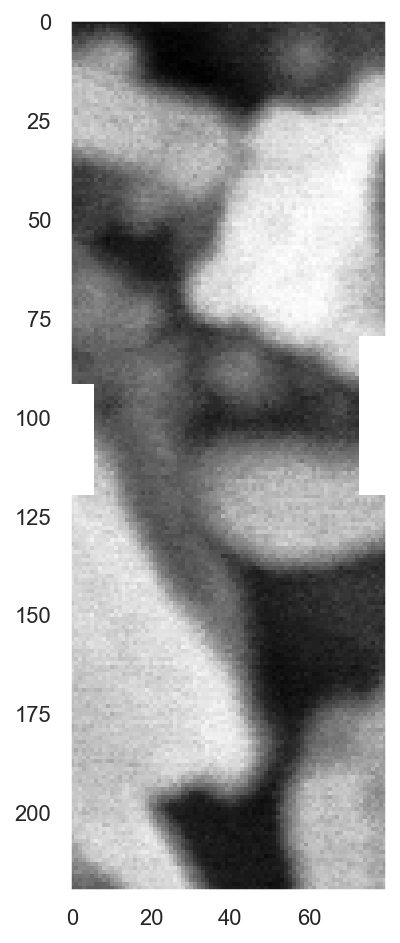

In [409]:
plot_image(im[1700:, 2060:2140], scale=1);

I think we are good with calling the interpixel distance 75 pixels. Let's compute the diameter. We also exclude some particles that are more ellipsiod shaped than shaped like a circle. Finally, we look at the distribution of obtained diameters.

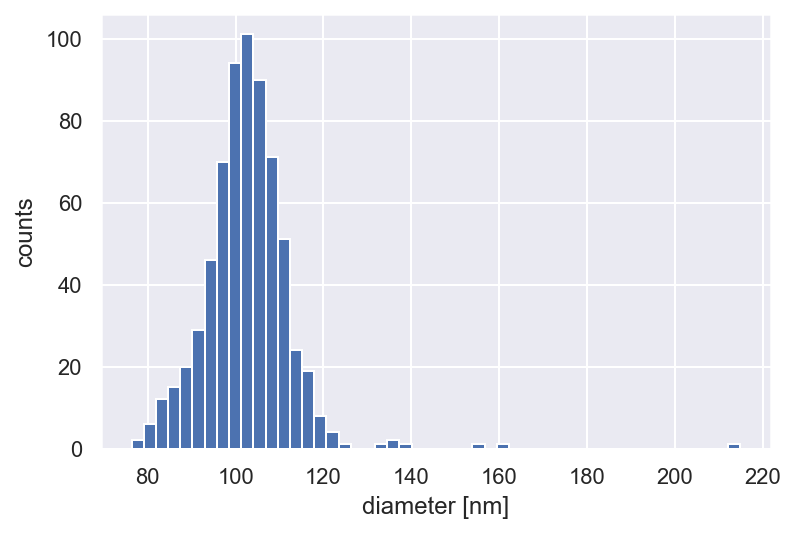

In [419]:
# Filter for round objects
df_filt = df.loc[df.eccentricity < 0.6, :]

# Compute diameter
df_filt['diameter [nm]'] = np.sqrt(df_filt['area (sq ip distance)'].values / np.pi) * 500/75 * 2

# Plot histogram
plt.hist(df_filt['diameter [nm]'], bins=50)
plt.xlabel("diameter [nm]")
plt.ylabel('counts');

Most virions seem to have a diameter around 100nm, which is close to the value described in the literature. There are some outliers, which could be overlapping virions or other objects which we were not able to remove in the filtering process. Let's look at the median of our obtained values.

In [420]:
np.median(df_filt['diameter [nm]'])

102.31743975947386